**Chapter 4 – Training Linear Models**

Texts and code from A. Géron, Hands-on Machine Learning with Scikit Learn, Keras and TensorFlow, 3rd edition, O'Reilly, 2022.

# Polynomial Regression

What if your data is more complex than a straight line? Surprisingly, you can use a
linear model to fit nonlinear data. A simple way to do this is to add powers of each
feature as new features, then train a linear model on this extended set of features. This
technique is called *polynomial regression*.

Let’s look at an example. First, we’ll generate some nonlinear data, based on a simple quadratic equation, i.e., an equation of the form $y = ax^2 + bx + c$, plus some noise.

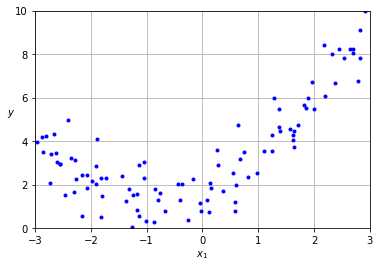

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s
`PolynomialFeatures` class to transform our training data, adding the square (seconddegree
polynomial) of each feature in the training set as a new feature (in this case
there is just one feature):

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print("Original feature: ", X[0])
print("Original feature and its square: ", X_poly[0])

Original feature:  [-0.75275929]
Original feature and its square:  [-0.75275929]


Now we can fit a `LinearRegression` model to this extended training data

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

Not bad: the model estimates $\hat{y} = 0.56x_1^2 + 0.93x_1 + 1.78$ when the original function was $y = 0.5x_1^2 + 1.0x_1 +2.0 + $ Gaussian noise.

Note that when there are multiple features, polynomial regression is capable of
finding relationships between features, which is something a plain linear regression
model cannot do. This is made possible by the fact that `PolynomialFeatures` also
adds all combinations of features up to the given degree. For example, if there were
two features $a$ and $b$, `PolynomialFeatures` with `degree=3` would not only add the
features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations $ab$, $a^2 b$, and $ab^2$.

# Learning Curves

If you perform high-degree polynomial regression, you will likely fit the training data
much better than with plain linear regression. 

But in general you won’t know what function generated the
data, so how can you decide how complex your model should be? How can you tell
that your model is overfitting or underfitting the data?

In Chapter 2 you used cross-validation to get an estimate of a model’s generalization
performance. If a model performs well on the training data but generalizes poorly
according to the cross-validation metrics, then your model is overfitting. If it performs
poorly on both, then it is underfitting. This is one way to tell when a model is
too simple or too complex.

Another way to tell is to look at the learning curves, which are plots of the model’s
training error and validation error as a function of the training iteration: just evaluate
the model at regular intervals during training on both the training set and the
validation set, and plot the results.

Scikit-Learn has a useful `learning_curve()` function to help with this: it trains
and evaluates the model using cross-validation. By default it retrains the model on
growing subsets of the training set, but if the model supports incremental learning
you can set `exploit_incremental_learning=True` when calling `learning_curve()`
and it will train the model incrementally instead.

The function returns the training
set sizes at which it evaluated the model, and the training and validation scores it measured for each size and for each cross-validation fold. Let’s use this function to
look at the learning curves of the plain linear regression model

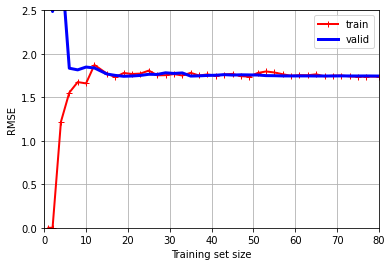

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.show()

This model is underfitting. To see why, first let’s look at the training error. When there
are just one or two instances in the training set, the model can fit them perfectly,
which is why the curve starts at zero.

But as new instances are added to the training
set, it becomes impossible for the model to fit the training data perfectly, both because
the data is noisy and because it is not linear at all.

So the error on the training
data goes up until it reaches a plateau, at which point adding new instances to the
training set doesn’t make the average error much better or worse

Now let’s look at
the validation error. When the model is trained on very few training instances, it is
incapable of generalizing properly, which is why the validation error is initially quite
large. Then, as the model is shown more training examples, it learns, and thus the
validation error slowly goes down.

However, once again a straight line cannot do a
good job of modeling the data, so the error ends up at a plateau, very close to the
other curve.

**These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.**

Now let’s look at the learning curves of a 10th-degree polynomial model on the same
data:

In [ ]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

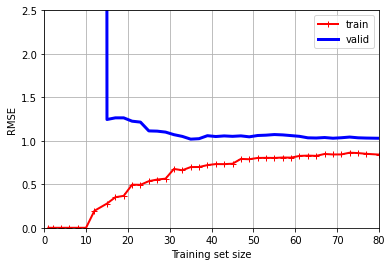

In [ ]:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

These learning curves look a bit like the previous ones, but there are two very
important differences:



*   The error on the training data is much lower than before.
*   There is a gap between the curves. This means that the model performs significantly better on the training data than on the validatation data, which is the hallmark of an overfitting model. With a larger training set, however, the two curves would continue to get closer.



Finally, let's see the curves for the best model in this case:

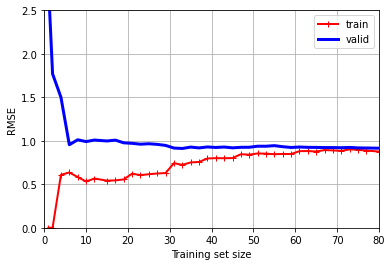

In [ ]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

# The Bias/Variance Trade-Off

An important theoretical result of statistics and machine learning is the fact that
a model’s generalization error can be expressed as the sum of three very different
errors:

*Bias*


> This part of the generalization error is due to wrong assumptions, such as
assuming that the data is linear when it is actually quadratic. A high-bias model
is most likely to underfit the training data



*Variance*


> This part is due to the model’s excessive sensitivity to small variations in the
training data. A model with many degrees of freedom (such as a high-degree
polynomial model) is likely to have high variance and thus overfit the training
data.



*Irreducible error*


> This part is due to the noisiness of the data itself. The only way to reduce this
part of the error is to clean up the data (e.g., fix the data sources, such as broken
sensors, or detect and remove outliers).



**Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off.**

# Regularized Linear Models

As you saw in Chapters 1 and 2, a good way to reduce overfitting is to regularize the
model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be
for it to overfit the data.

For a linear model, regularization is typically achieved by constraining the weights
of the model. We will now look at ridge regression, lasso regression, and elastic net
regression, which implement three different ways to constrain the weights.

# Ridge Regression

Ridge regression (also called Tikhonov regularization) is a regularized version of linear
regression: a regularization term equal to $\frac{\alpha}{m} \sum_{i=1}^{n}{\theta _i ^2}$ is added to the MSE: $J(\boldsymbol{\theta}) = \mathrm{MSE}(\boldsymbol{\theta}) + \frac{\alpha}{m} \sum_{i=1}^{n}{\theta _i ^2}$

This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible.

Note that the regularization term should only be added to
the cost function during training. Once the model is trained, you want to use the
unregularized MSE (or the RMSE) to evaluate the model’s performance

The hyperparameter $\alpha$ controls how much you want to regularize the model. If $\alpha = 0$, then ridge regression is just linear regression. If $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going thorugh the data's mean.

Here is how to perform ridge regression with Scikit-Learn using a closed-form
solution (using a matrix factorization technique by
André-Louis Cholesky):

In [ ]:
# extra code – we've done this type of generation several times before
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

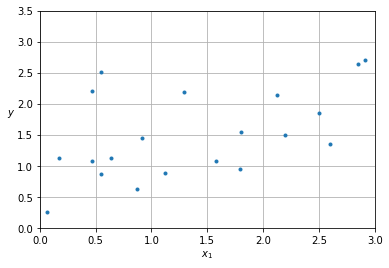

In [ ]:
# extra code – a quick peek at the dataset we just generated
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [ ]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

And using stochastic gradient descent:

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([1.55302613])

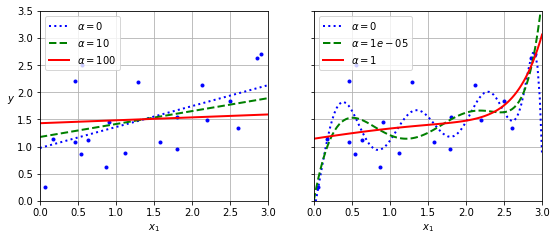

In [ ]:
# extra code – this cell generates and saves Figure 4–17

from sklearn.preprocessing import StandardScaler

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

# Lasso Regression

Least absolute shrinkage and selection operator regression (usually simply called lasso
regression) is another regularized version of linear regression: just like ridge regression,
it adds a regularization term to the cost function, but it uses the $ℓ_1$ norm of
the weight vector instead of the square of the $ℓ_2$ norm. The cost function is  $J(\boldsymbol{\theta}) = \mathrm{MSE}(\boldsymbol{\theta}) +2\alpha \sum _{i=1}^{n} \left| \theta_i \right|$. 

Here is a small Scikit-Learn example using the Lasso class:

In [ ]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

Note that you could instead use `SGDRegressor(penalty="l1", alpha=0.1)`.

An important characteristic of lasso regression is that it tends to eliminate the weights
of the least important features (i.e., set them to zero). For example, the dashed line
in the righthand plot below (with α = 0.01) looks roughly cubic: all the
weights for the high-degree polynomial features are equal to zero. In other words,
lasso regression automatically performs feature selection and outputs a sparse model
with few nonzero feature weights.

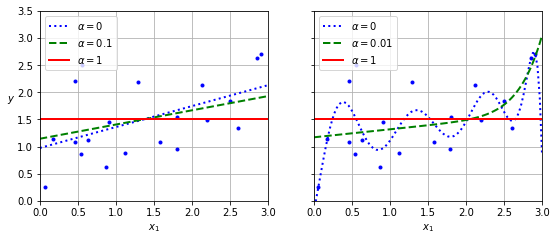

In [ ]:
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

# Elastic Net Regression

Elastic net regression is a middle ground between ridge regression and lasso regression.
The regularization term is a weighted sum of both ridge and lasso’s regularization
terms, and you can control the mix ratio r. When r = 0, elastic net is equivalent
to ridge regression, and when r = 1, it is equivalent to lasso regression:

$J(\boldsymbol{\theta}) = \mathrm{MSE}(\boldsymbol{\theta}) + r \left( 2\alpha \sum _{i=1}^{n} \left| \theta_i \right| \right) + (1-r) \left( \frac{\alpha}{m} \sum_{i=1}^{n}{\theta _i ^2} \right)$

So when should you use elastic net regression, or ridge, lasso, or plain linear regression
(i.e., without any regularization)? It is almost always preferable to have at least
a little bit of regularization, so generally you should avoid plain linear regression.


Ridge is a good default, but if you suspect that only a few features are useful, you
should prefer lasso or elastic net because they tend to reduce the useless features’
weights down to zero, as discussed earlier.

In general, elastic net is preferred over lasso because lasso may behave erratically when the number of features is greater than
the number of training instances or when several features are strongly correlated.

Here is a short example that uses Scikit-Learn’s ElasticNet (`l1_ratio` corresponds to
the mix ratio `r`):

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

# Early Stopping

A very different way to regularize iterative learning algorithms such as gradient
descent is to stop training as soon as the validation error reaches a minimum. This is
called *early stopping*.

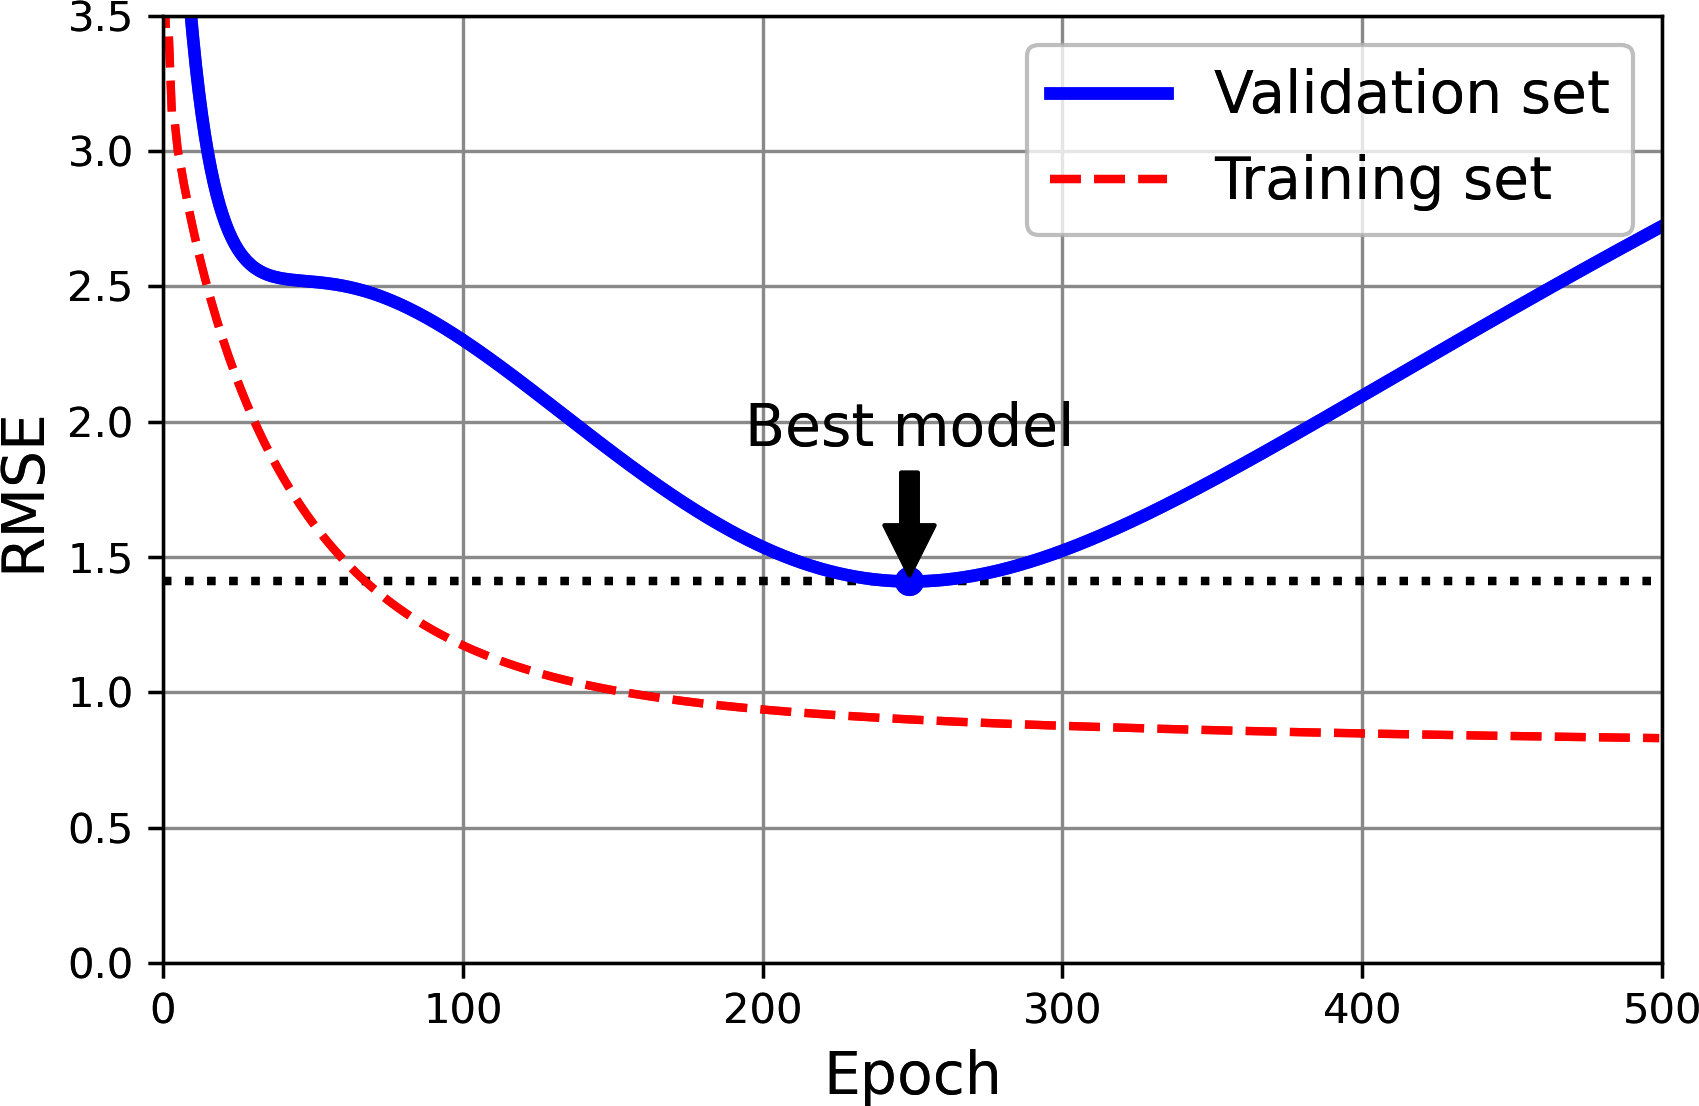

As the epochs go by, the algorithm learns, and its
prediction error (RMSE) on the training set goes down, along with its prediction
error on the validation set.

After a while, though, the validation error stops decreasing
and starts to go back up. This indicates that the model has started to overfit the
training data.

With early stopping you just stop training as soon as the validation
error reaches the minimum. It is such a simple and efficient regularization technique
that Geoffrey Hinton called it a “beautiful free lunch”.

Here is a basic implementation of early stopping:

In [ ]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

This code first adds the polynomial features and scales all the input features, both
for the training set and for the validation set (the code assumes that you have split
the original training set into a smaller training set and a validation set).

Then it
creates an SGDRegressor model with no regularization and a small learning rate. In
the training loop, it calls partial_fit() instead of fit(), to perform incremental
learning.

At each epoch, it measures the RMSE on the validation set. If it is lower
than the lowest RMSE seen so far, it saves a copy of the model in the best_model
variable.

This implementation does not actually stop training, but it lets you revert to
the best model after training.

Note that the model is copied using `copy.deepcopy()`,
because it copies both the model’s hyperparameters and the learned parameters. In
contrast, `sklearn.base.clone()` only copies the model’s hyperparameters.